# 1. Preprocessing & Load data

In [289]:
import os
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import sys
import seaborn as sns
import pandas as pd
import time

In [274]:
rootpath = "../Dataset"

## 1.1 Load the data and preprocessing

In [275]:
# Read in images from a filepath as graycsale
date = "2018-07-09-16-11-56_2018-07-09-16-51-40-823-"
imgL= cv2.imread(os.path.join(rootpath, date+"left.jpg"),cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(os.path.join(rootpath, date+"right.jpg"),cv2.IMREAD_GRAYSCALE)
imgTruth = cv2.imread(os.path.join(rootpath, date+"disparity.png"),cv2.IMREAD_GRAYSCALE)


Shape of imgL    :  (400, 881)
Shape of imgR    :  (400, 881)
Shape of imgTruth:  (400, 881)


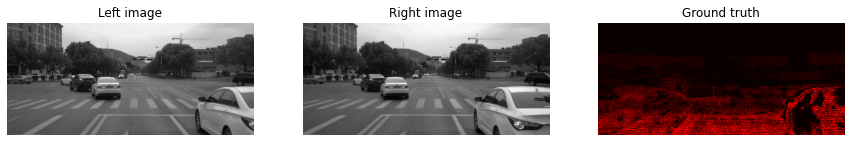

In [276]:
print("Shape of imgL    : ", imgL.shape)
print("Shape of imgR    : ", imgR.shape)
print("Shape of imgTruth: ", imgTruth.shape)

plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(imgL, cmap='gray')  
plt.title('Left image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(imgR, cmap='gray')  
plt.title('Right image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(imgTruth, cmap='hot')  
plt.title('Ground truth')
plt.axis('off')

plt.show()

## 1.2 Check for rectification 

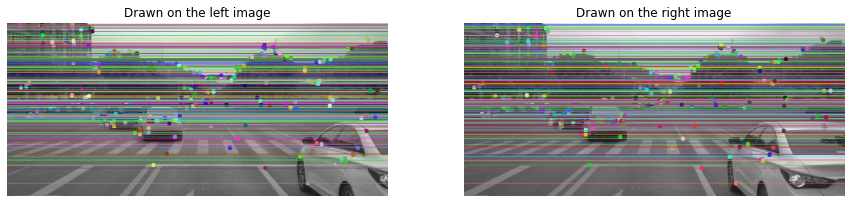

In [277]:
# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
ptsL = []
ptsR = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8 *n.distance: # was 0.7
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)

ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)


F, mask = cv2.findFundamentalMat(ptsL,ptsR,cv2.FM_LMEDS)

# Select only inlier points
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]


# create a function to draw epilines over the images
# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2


# Find epilines corresponding to points in right image 
# and draw its lines on left image
linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 


- The epipolar lines are parallel and epipoles are met at infinity 
- No need for rectification

## 1.3 Get stereo depth map from cv2.StereoBM_create

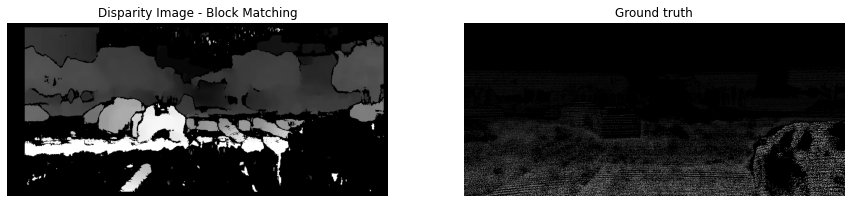

In [278]:
# Computing stereo correspondence using the block matching algorithm.
# Initialize the stereo block matching object 
''' numDisparities - the disparity search range. For each pixel algorithm will find 
                     the best disparity from 0 (default minimum disparity) to numDisparities. 
                     The search range can then be shifted by changing the minimum disparity.
    blockSize - the linear size of the blocks compared by the algorithm. 
                The size should be odd (as the block is centered at the current pixel). 
                Larger block size implies smoother, though less accurate disparity map. 
                Smaller block size gives more detailed disparity map, 
                but there is higher chance for algorithm to find a wrong correspondence. '''
num_disp = 32 # try to tune the parameters to get better&smooth result
block_size = 21
stereoBM = cv2.StereoBM_create(numDisparities=num_disp,
                             blockSize=block_size)

# Compute the disparity image
disparityBM = stereoBM.compute(imgL,imgR)

# Scale the pixel values to between 0-255 (Or you can normalized to [0,1])
min_val = disparityBM.min()
max_val = disparityBM.max()
disparityBM = ((disparityBM - min_val) / (max_val - min_val)*255).astype(np.uint8)


plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(disparityBM,'gray')
plt.title('Disparity Image - Block Matching')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(imgTruth, 'gray')  
plt.title('Ground truth')
plt.axis('off')

plt.show()

# Local Correspondence

In [279]:
# Find the disparity map with various options
def fastLocalStereo(stereoType, imgL, imgR, window_size, norm_mean=False, norm_std=False,blur="avg", D=100,  verbose=False):
    
    assert(imgL.shape==imgR.shape)
    
    # reassign data type allow for more accurate calculation
    imgL = imgL.astype('float64')
    imgR = imgR.astype('float64')
    
    
    
    numerator = np.ones(imgL.shape, np.float64)
    denominator = np.ones(imgL.shape, np.float64)
    
    
    # Normalizing the mean
    if norm_mean:
        imgL = imgL-cv2.blur(imgL, window_size)
        imgR = imgR-cv2.blur(imgR, window_size)
    
    
    # find the log disparity when d=0
    best_log_disp = calculateLogDisp(stereoType, imgL, imgR, window_size, norm_std, blur)
    best_ind = np.zeros(imgL.shape)
    
    
    prev_img = imgR
    
    # each time shift the imgR and using conv2d to get DSI and find disparity map
    for d in range(1, D):
        
        if (verbose and d%100==0):
            print("==finish {} iterations==".format(i))
        
        curr_img = np.hstack((prev_img[:,1:], prev_img[:,[0]])).astype('float64')
        
        
        curr_log_disp = calculateLogDisp(stereoType, imgL, curr_img, window_size, norm_std, blur)
        
        best_ind[curr_log_disp<best_log_disp] = d
        best_log_disp = np.minimum(best_log_disp, curr_log_disp)
        prev_img = curr_img
        
        if verbose:
            print('best_ind: ', best_ind)
            print('best_disp: ',best_log_disp)
    
    return best_ind
    
    

# 2. Calculate Global Correspondence

In [280]:
# Code for test 
imgL= cv2.imread(os.path.join(rootpath, date+"left.jpg"),cv2.IMREAD_GRAYSCALE)
imgR= cv2.imread(os.path.join(rootpath, date+"right.jpg"),cv2.IMREAD_GRAYSCALE)

# imgL = imgL[0:30,0:30].astype('uint64')
# imgR = imgR[0:30,0:30].astype('uint64')

print("imgL.shape: ",imgL.shape)
print("imgR.shape: ",imgR.shape)


imgL.shape:  (400, 881)
imgR.shape:  (400, 881)


## 2.1 intrascanline search

In [309]:
# calcualte the rmse
def rms_error(img, imgTruth=imgTruth):
    mask = imgTruth!=0
    return np.sqrt(np.sum(((img-imgTruth)**2)[mask])/(np.sum(mask)+1e-10))

In [310]:
# fraction of disparities less than threshold
def fraction(img, truth, thres):
    mask = truth!=0
    return np.sum(np.logical_and(np.abs(img-truth)<thres, mask)/(np.sum(mask)+1e-10))

In [282]:
# filter img using various smoothing method
def filter_img(img, window_size, blur):
    if blur=="avg":
        return cv2.blur(img,window_size)
    if blur=="gau":
        return cv2.GaussianBlur(img,window_size,0)
    else:
        return cv2.medianBlur(np.uint8(img),window_size[0]).astype('float64')

In [283]:
# calculate the log disparity between two images give stereotype
def calculateLogDisp(stereoType, imgL, imgR, window_size, norm_std, blur):
    
    denominator = np.ones(imgL.shape, np.float64)
    
    
    # Calculate the numerator using formula
    if (stereoType=="SAD"):
        numerator = filter_img(np.abs(imgR-imgL),window_size, blur)
    elif (stereoType=="SSD"):
        numerator = filter_img((imgR-imgL)**2,window_size, blur)
    else:
        numerator = filter_img(np.abs(imgR*imgL),window_size, blur)
    
    # Calculate the denominator: normalizing terms
    if norm_std:
        denominator = filter_img(imgR**2,window_size, blur)
        
    
    # Calculate the log disparities
    if (stereoType=="SAD" or stereoType=="SSD"):
        best_log_disp = np.log(numerator+1e-10)-0.5*np.log(denominator+1e-10)
    else:
        best_log_disp = -1*(np.log(numerator+1e-10)-0.5*np.log(denominator+1e-10))
    
    return best_log_disp


In [320]:
# search for disparities on shortest path
def intralineSearch(disparity_space, use_soft = False, verbose=False):
    
    assert(len(disparity_space.shape)==3)
    
    d_space = []
    for i in range(disparity_space.shape[0]):
        if (verbose and i%10==0):
            print("==finish {} searches ==".format(i))
        disparity_map = np.transpose(disparity_space[i])
        
        
        # distance_map has value of total path; index has index for where does path from
        distance_map = np.array(disparity_map,copy=True).astype('float128')
        
        distance_map[:,1:]=0
        index_map = np.zeros(disparity_map.shape,'int64')
        
        height = disparity_map.shape[0]
        width = disparity_map.shape[1]

        for j in range(1,width):
            for i in range(height):
                if (i==0):
                    distance_map[i,j] = min(distance_map[i,j-1],distance_map[i+1,j-1])
                    index_map[i,j] = [i,i+1][np.argmin((distance_map[i,j-1],distance_map[i+1,j-1]))]
                elif (i==height-1):
                    distance_map[i,j] = min(distance_map[i,j-1],distance_map[i-1,j-1])
                    index_map[i,j] = [i,i-1][np.argmin((distance_map[i,j-1],distance_map[i-1,j-1]))]
                else:
                    distance_map[i,j] = min(distance_map[i,j-1],distance_map[i-1,j-1],distance_map[i+1,j-1])
                    index_map[i,j] = [i,i-1,i+1][np.argmin((distance_map[i,j-1],distance_map[i-1,j-1],distance_map[i+1,j-1]))]
                distance_map[i,j]+=disparity_map[i,j]
        
        
        # Get the index of shortest path; use_soft refers using DP-SO
        ind_lst = []
        ind = np.argmin(distance_map[:,-1])
        if use_soft:
            disparity_map[ind,-1] = disparity_map[ind,-1]*0.8
        ind_lst.insert(0,ind)
        for i in range(width-1,0,-1):
            ind = index_map[ind,i]
            if use_soft:
                disparity_map[ind,i-1] = disparity_map[ind,i-1]*0.8
            ind_lst.insert(0,ind)
        if use_soft:
            d_space.append(np.argmin(disparity_map, axis=0))
            
        else:
            


            
    return np.vstack(d_space)



In [315]:
# Find the disparity map using global method
def fastGlobalStereo(stereoType, imgL, imgR, window_size, norm_mean=False, norm_std=False,blur="avg", use_soft=False, D=100, verbose=False):
    assert(imgL.shape==imgR.shape)
    
    imgL = imgL.astype('float64')
    imgR = imgR.astype('float64')
    
    
    numerator = np.ones(imgL.shape, np.float64)
    denominator = np.ones(imgL.shape, np.float64)
    
    
    # normalise mean
    if norm_mean:
        imgL = imgL-cv2.blur(imgL, window_size)
        imgR = imgR-cv2.blur(imgR, window_size)
    
    
    
    disparity_space = []
    best_ind = np.zeros(imgL.shape)
    
    
    prev_img = imgR
    
    for d in range(D):
        
        if (verbose and d%100==0):
            print("==finish {} iterations==".format(d))
        
        # get log disparity value
        log_disp = calculateLogDisp(stereoType, imgL, prev_img, window_size, norm_std,blur)
        disparity_space.append(np.expand_dims(log_disp, axis=-1))
                                    
        # shift the right image
        next_img = np.hstack((prev_img[:,1:], prev_img[:,[0]])).astype('float64')
        prev_img = next_img
        
        
    # disparity_space: DSI for scanlines
    disparity_space = np.concatenate(disparity_space,axis=-1)
    
    return intralineSearch(disparity_space,use_soft,  True)
    
    
    
    

# Results

In [321]:
dates = ["2018-07-09-16-11-56_2018-07-09-16-11-56-702-",
        "2018-07-09-16-11-56_2018-07-09-16-13-38-366-",
        "2018-07-09-16-11-56_2018-07-09-16-14-54-205-",
        "2018-07-09-16-11-56_2018-07-09-16-16-13-272-",
        "2018-07-09-16-11-56_2018-07-09-16-25-10-570-",
        "2018-07-09-16-11-56_2018-07-09-16-26-00-067-",
        "2018-07-09-16-11-56_2018-07-09-16-27-53-156-",
        "2018-07-09-16-11-56_2018-07-09-16-29-12-297-",
        "2018-07-09-16-11-56_2018-07-09-16-29-56-824-",
        "2018-07-09-16-11-56_2018-07-09-16-30-47-660-"]

thres = [4, 2, 1, 0.5, 0.25]

In [322]:

res_ZSSD_Glo_Hard = []
res_ZSSD_Glo_Soft = []
res_ZSSD_Loc = []

frac_4_ZSSD_Glo_Hard = []
frac_4_ZSSD_Glo_Soft = []
frac_4_ZSSD_Loc = []

frac_2_ZSSD_Glo_Hard = []
frac_2_ZSSD_Glo_Soft = []
frac_2_ZSSD_Loc = []

frac_1_ZSSD_Glo_Hard = []
frac_1_ZSSD_Glo_Soft = []
frac_1_ZSSD_Loc = []

frac_0_5_ZSSD_Glo_Hard = []
frac_0_5_ZSSD_Glo_Soft = []
frac_0_5_ZSSD_Loc = []

frac_0_25_ZSSD_Glo_Hard = []
frac_0_25_ZSSD_Glo_Soft = []
frac_0_25_ZSSD_Loc = []


time_ZSSD_Glo_Hard = []
time_ZSSD_Glo_Soft = []
time_ZSSD_Loc = []



for date in dates:
    print("=========================================================")
    imgL= cv2.imread(os.path.join(rootpath, date+"left.jpg"),cv2.IMREAD_GRAYSCALE)
    imgR = cv2.imread(os.path.join(rootpath, date+"right.jpg"),cv2.IMREAD_GRAYSCALE)
    imgTruth = cv2.imread(os.path.join(rootpath, date+"disparity.png"),cv2.IMREAD_GRAYSCALE)

    
    k=35
    k_n=95
    
    
    start_time = time.time()
    d_ZSSD_Loc = fastLocalStereo("SSD", imgL, imgR, (k,k),True, True)
    
    time_ZSSD_Loc.append(time.time()-start_time)
    
    res_ZSSD_Loc.append(rms_error(d_ZSSD_Loc, imgTruth))
    print("size = ",k," d_ZSSD_Loc = ",rms_error(d_ZSSD_Loc,imgTruth))
    frac_4_ZSSD_Loc.append(fraction(d_ZSSD_Loc, imgTruth,4))
    frac_2_ZSSD_Loc.append(fraction(d_ZSSD_Loc, imgTruth,2))
    frac_1_ZSSD_Loc.append(fraction(d_ZSSD_Loc, imgTruth,1))
    frac_0_5_ZSSD_Loc.append(fraction(d_ZSSD_Loc, imgTruth,0.5))
    frac_0_25_ZSSD_Loc.append(fraction(d_ZSSD_Loc, imgTruth,0.25))
    
    
    
    
    start_time = time.time()
    d_ZSSD_Glo_Soft = fastGlobalStereo("SSD", imgL, imgR, (k,k),True, True, use_soft=True)
    time_ZSSD_Glo_Soft.append(time.time()-start_time)
    
    res_ZSSD_Glo_Soft.append(rms_error(d_ZSSD_Glo_Soft, imgTruth))
    print("size = ",k," d_ZSSD_Loc = ",rms_error(d_ZSSD_Glo_Soft,imgTruth))
    
    frac_4_ZSSD_Glo_Soft.append(fraction(d_ZSSD_Glo_Soft, imgTruth,4))
    frac_2_ZSSD_Glo_Soft.append(fraction(d_ZSSD_Glo_Soft, imgTruth,2))
    frac_1_ZSSD_Glo_Soft.append(fraction(d_ZSSD_Glo_Soft, imgTruth,1))
    frac_0_5_ZSSD_Glo_Soft.append(fraction(d_ZSSD_Glo_Soft, imgTruth,0.5))
    frac_0_25_ZSSD_Glo_Soft.append(fraction(d_ZSSD_Glo_Soft, imgTruth,0.25))
    
    
    
    
    
    
    
    start_time = time.time()
    d_ZSSD_Glo_Hard = fastGlobalStereo("SSD", imgL, imgR, (k,k),True, True, use_soft=False)
    time_ZSSD_Glo_Hard.append(time.time()-start_time)
    
    res_ZSSD_Glo_Hard.append(rms_error(d_ZSSD_Glo_Hard, imgTruth))
    print("size = ",k," d_ZSSD_Loc = ",rms_error(d_ZSSD_Glo_Hard,imgTruth))
    
    frac_4_ZSSD_Glo_Hard.append(fraction(d_ZSSD_Glo_Hard, imgTruth,4))
    frac_2_ZSSD_Glo_Hard.append(fraction(d_ZSSD_Glo_Hard, imgTruth,2))
    frac_1_ZSSD_Glo_Hard.append(fraction(d_ZSSD_Glo_Hard, imgTruth,1))
    frac_0_5_ZSSD_Glo_Hard.append(fraction(d_ZSSD_Glo_Hard, imgTruth,0.5))
    frac_0_25_ZSSD_Glo_Hard.append(fraction(d_ZSSD_Glo_Hard, imgTruth,0.25))
    
    
    
    
    

size =  35  d_ZSSD_Loc =  36.229713723163094
==finish 0 searches ==
==finish 10 searches ==
==finish 20 searches ==
==finish 30 searches ==
==finish 40 searches ==
==finish 50 searches ==
==finish 60 searches ==
==finish 70 searches ==
==finish 80 searches ==
==finish 90 searches ==
==finish 100 searches ==
==finish 110 searches ==
==finish 120 searches ==
==finish 130 searches ==
==finish 140 searches ==
==finish 150 searches ==
==finish 160 searches ==
==finish 170 searches ==
==finish 180 searches ==
==finish 190 searches ==
==finish 200 searches ==
==finish 210 searches ==
==finish 220 searches ==
==finish 230 searches ==
==finish 240 searches ==
==finish 250 searches ==
==finish 260 searches ==
==finish 270 searches ==
==finish 280 searches ==
==finish 290 searches ==
==finish 300 searches ==
==finish 310 searches ==
==finish 320 searches ==
==finish 330 searches ==
==finish 340 searches ==
==finish 350 searches ==
==finish 360 searches ==
==finish 370 searches ==
==finish 380 sea

==finish 230 searches ==
==finish 240 searches ==
==finish 250 searches ==
==finish 260 searches ==
==finish 270 searches ==
==finish 280 searches ==
==finish 290 searches ==
==finish 300 searches ==
==finish 310 searches ==
==finish 320 searches ==
==finish 330 searches ==
==finish 340 searches ==
==finish 350 searches ==
==finish 360 searches ==
==finish 370 searches ==
==finish 380 searches ==
==finish 390 searches ==
size =  35  d_ZSSD_Loc =  27.088501790886152
size =  35  d_ZSSD_Loc =  38.431620043560464
==finish 0 searches ==
==finish 10 searches ==
==finish 20 searches ==
==finish 30 searches ==
==finish 40 searches ==
==finish 50 searches ==
==finish 60 searches ==
==finish 70 searches ==
==finish 80 searches ==
==finish 90 searches ==
==finish 100 searches ==
==finish 110 searches ==
==finish 120 searches ==
==finish 130 searches ==
==finish 140 searches ==
==finish 150 searches ==
==finish 160 searches ==
==finish 170 searches ==
==finish 180 searches ==
==finish 190 searches

==finish 40 searches ==
==finish 50 searches ==
==finish 60 searches ==
==finish 70 searches ==
==finish 80 searches ==
==finish 90 searches ==
==finish 100 searches ==
==finish 110 searches ==
==finish 120 searches ==
==finish 130 searches ==
==finish 140 searches ==
==finish 150 searches ==
==finish 160 searches ==
==finish 170 searches ==
==finish 180 searches ==
==finish 190 searches ==
==finish 200 searches ==
==finish 210 searches ==
==finish 220 searches ==
==finish 230 searches ==
==finish 240 searches ==
==finish 250 searches ==
==finish 260 searches ==
==finish 270 searches ==
==finish 280 searches ==
==finish 290 searches ==
==finish 300 searches ==
==finish 310 searches ==
==finish 320 searches ==
==finish 330 searches ==
==finish 340 searches ==
==finish 350 searches ==
==finish 360 searches ==
==finish 370 searches ==
==finish 380 searches ==
==finish 390 searches ==
size =  35  d_ZSSD_Loc =  25.130508514378775
size =  35  d_ZSSD_Loc =  28.583158927616644
==finish 0 searc

In [324]:

print("res_ZSSD_Glo_Hard: ", np.mean(res_ZSSD_Glo_Hard), np.std(res_ZSSD_Glo_Hard))
print("res_ZSSD_Glo_Soft: ", np.mean(res_ZSSD_Glo_Soft), np.std(res_ZSSD_Glo_Soft))
print("res_ZSSD_Loc: ", np.mean(res_ZSSD_Loc), np.std(res_ZSSD_Loc))

print("frac_4_ZSSD_Glo_Hard: ", np.mean(frac_4_ZSSD_Glo_Hard), np.std(frac_4_ZSSD_Glo_Hard))
print("frac_4_ZSSD_Glo_Soft: ", np.mean(frac_4_ZSSD_Glo_Soft), np.std(frac_4_ZSSD_Glo_Soft))
print("frac_4_ZSSD_Loc: ", np.mean(frac_4_ZSSD_Loc), np.std(frac_4_ZSSD_Loc))


print("frac_2_ZSSD_Glo_Hard: ", np.mean(frac_2_ZSSD_Glo_Hard), np.std(frac_2_ZSSD_Glo_Hard))
print("frac_2_ZSSD_Glo_Soft: ", np.mean(frac_2_ZSSD_Glo_Soft), np.std(frac_2_ZSSD_Glo_Soft))
print("frac_2_ZSSD_Loc: ", np.mean(frac_2_ZSSD_Loc), np.std(frac_2_ZSSD_Loc))


print("frac_1_ZSSD_Glo_Hard: ", np.mean(frac_1_ZSSD_Glo_Hard), np.std(frac_1_ZSSD_Glo_Hard))
print("frac_1_ZSSD_Glo_Soft: ", np.mean(frac_1_ZSSD_Glo_Soft), np.std(frac_1_ZSSD_Glo_Soft))
print("frac_1_ZSSD_Loc: ", np.mean(frac_1_ZSSD_Loc), np.std(frac_1_ZSSD_Loc))\

print("frac_0_5_ZSSD_Glo_Hard: ", np.mean(frac_0_5_ZSSD_Glo_Hard), np.std(frac_0_5_ZSSD_Glo_Hard))
print("frac_0_5_ZSSD_Glo_Soft: ", np.mean(frac_0_5_ZSSD_Glo_Soft), np.std(frac_0_5_ZSSD_Glo_Soft))
print("frac_0_5_ZSSD_Loc: ", np.mean(frac_0_5_ZSSD_Loc), np.std(frac_0_5_ZSSD_Loc))


print("frac_0_25_ZSSD_Glo_Hard: ", np.mean(frac_0_25_ZSSD_Glo_Hard), np.std(frac_0_25_ZSSD_Glo_Hard))
print("frac_0_25_ZSSD_Glo_Soft: ", np.mean(frac_0_25_ZSSD_Glo_Soft), np.std(frac_0_25_ZSSD_Glo_Soft))
print("frac_0_25_ZSSD_Loc: ", np.mean(frac_0_25_ZSSD_Loc), np.std(frac_0_25_ZSSD_Loc))


print("time_ZSSD_Glo_Hard: ", np.mean(time_ZSSD_Glo_Hard), np.std(time_ZSSD_Glo_Hard))
print("time_ZSSD_Glo_Soft: ", np.mean(time_ZSSD_Glo_Soft), np.std(time_ZSSD_Glo_Soft))
print("time_ZSSD_Loc: ", np.mean(time_ZSSD_Loc), np.std(time_ZSSD_Loc))




res_ZSSD_Glo_Hard:  25.563562173965728 4.012014752550447
res_ZSSD_Glo_Soft:  26.66378651922276 4.1090095731725755
res_ZSSD_Loc:  33.31223841209187 3.1133988084888093
frac_4_ZSSD_Glo_Hard:  0.0903375043783936 0.03613082926628319
frac_4_ZSSD_Glo_Soft:  0.08927797556725921 0.03608915414266983
frac_4_ZSSD_Loc:  0.06787121756578984 0.03324118162642926
frac_2_ZSSD_Glo_Hard:  0.03884354024805424 0.01651354588276805
frac_2_ZSSD_Glo_Soft:  0.03839262060775166 0.016413265907096873
frac_2_ZSSD_Loc:  0.02914474308609391 0.015161274614733738
frac_1_ZSSD_Glo_Hard:  0.012746816611051603 0.005713467275028545
frac_1_ZSSD_Glo_Soft:  0.012631428274880774 0.00570686980962648
frac_1_ZSSD_Loc:  0.009542732068045066 0.005469385779559812
frac_0_5_ZSSD_Glo_Hard:  0.012746816611051603 0.005713467275028545
frac_0_5_ZSSD_Glo_Soft:  0.012631428274880774 0.00570686980962648
frac_0_5_ZSSD_Loc:  0.009542732068045066 0.005469385779559812
frac_0_25_ZSSD_Glo_Hard:  0.012746816611051603 0.005713467275028545
frac_0_25_ZSS

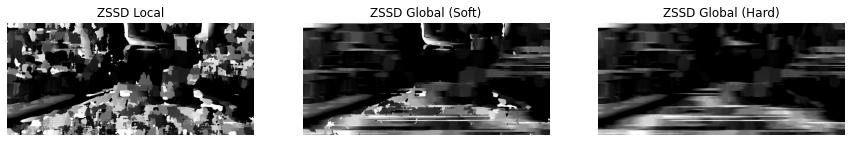

In [325]:
# plot for result image
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(d_ZSSD_Loc, 'gray')  
plt.title('ZSSD Local')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(d_ZSSD_Glo_Soft, 'gray')  
plt.title('ZSSD Global (Soft)')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(d_ZSSD_Glo_Hard, 'gray')  
plt.title('ZSSD Global (Hard)')
plt.axis('off')

plt.show()